## Регрессия
Задача: предсказать зарплату игрока НХЛ по его статистике с использованием модели решающего дерева.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель. В качестве дополнительной метрики будем использовать R^2, чтобы смотреть насколько отличается предсказание от среднего.

### Baseline

Скачаем датасет с kaggle

In [1]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [2]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [3]:
from sklearn.model_selection import train_test_split

TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [4]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dt = DecisionTreeRegressor(random_state=42, max_depth=None, min_samples_leaf=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, np.full(len(y_test), y_train.mean()))

print("--- Decision Tree Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Decision Tree Regressor ---
MAE: 1220967.395
R2 Score: 0.322


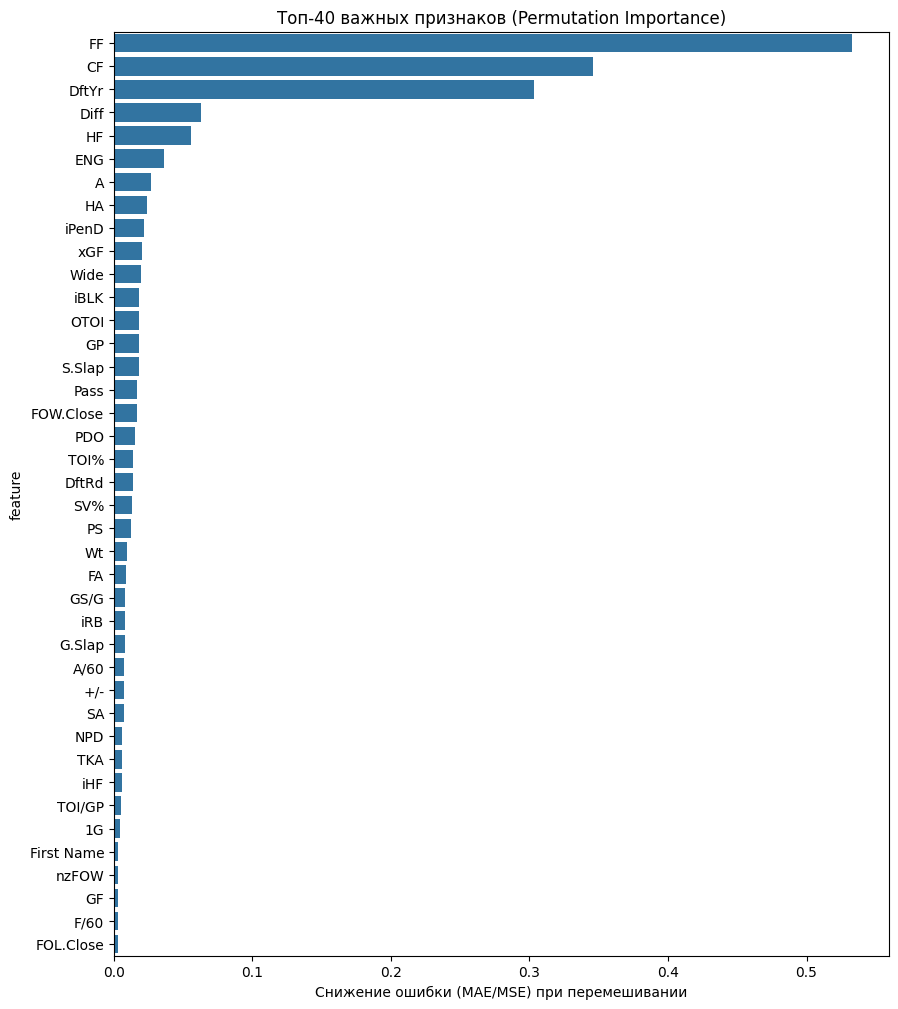

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.inspection import permutation_importance

def important_features(model, X_test, y_test):
    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()

important_features(dt, X_test, y_test)

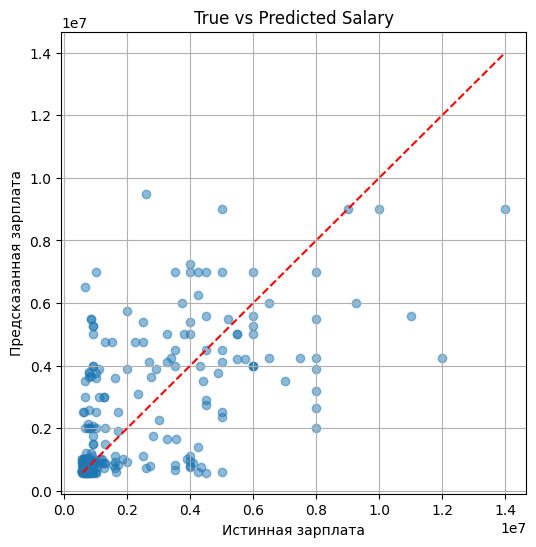

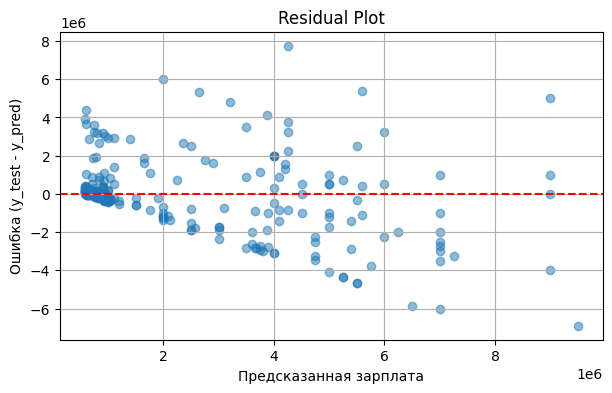

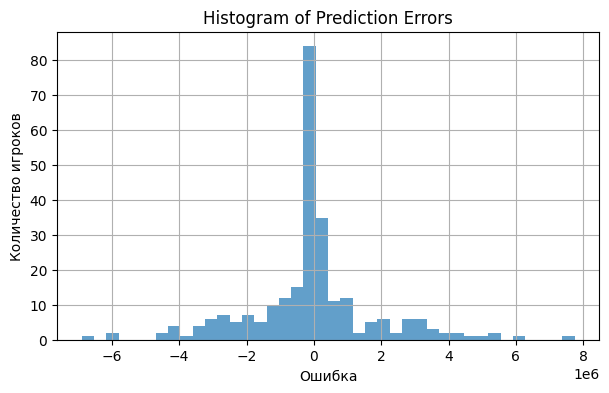

In [6]:
from matplotlib import pyplot as plt

def true_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Истинная зарплата")
    plt.ylabel("Предсказанная зарплата")
    plt.title("True vs Predicted Salary")
    plt.grid(True)
    plt.show()

def resudial(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанная зарплата")
    plt.ylabel("Ошибка (y_test - y_pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
def histogramm_error(y_test, y_pred):
    plt.figure(figsize=(7,4))
    residuals = y_test - y_pred
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Ошибка")
    plt.ylabel("Количество игроков")
    plt.grid(True)
    plt.show()
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

Решающее дерево на базовом пайплайне даёт так себе результаты, ошибки сильно разбросаны вокруг диагонали.

### Improved Desicion Tree

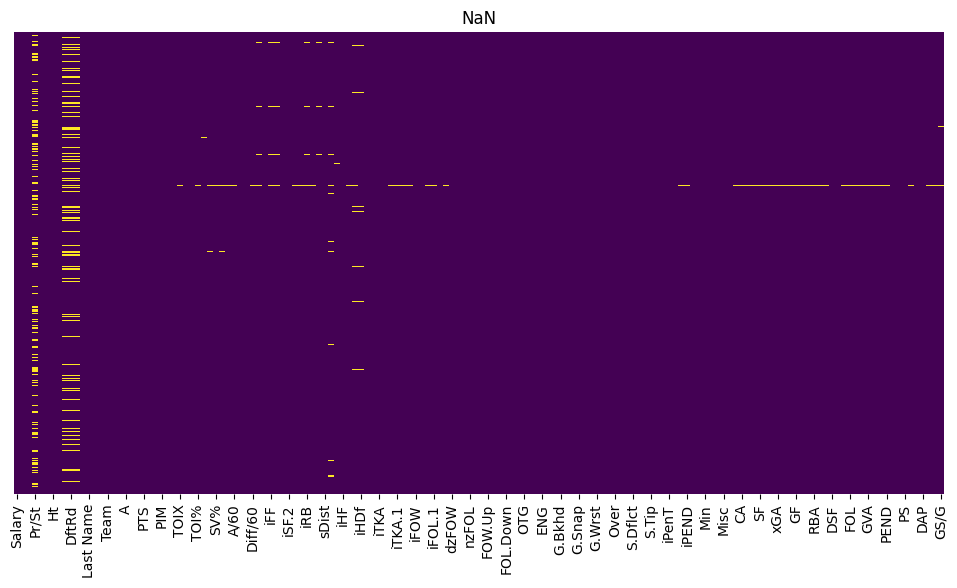

In [7]:
import kagglehub
from matplotlib import pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [8]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,874.0,2.325289e+06,2.298253e+06,575000.00,742500.00,925000.00,3700000.00,14000000.00
Ht,874.0,7.308238e+01,2.105485e+00,66.00,72.00,73.00,75.00,81.00
Wt,874.0,2.008432e+02,1.506008e+01,157.00,190.00,200.00,210.00,265.00
DftYr,749.0,2.008708e+03,4.380158e+00,1990.00,2006.00,2010.00,2012.00,2016.00
DftRd,749.0,2.742323e+00,1.988358e+00,1.00,1.00,2.00,4.00,9.00
...,...,...,...,...,...,...,...,...
Grit,874.0,1.267815e+02,1.016121e+02,0.00,41.00,114.00,190.00,622.00
DAP,874.0,9.215675e+00,7.815029e+00,0.00,4.60,7.60,12.00,61.00
Pace,873.0,1.089439e+02,8.899877e+00,75.00,104.70,109.20,113.90,175.70
GS,873.0,2.187331e+01,2.198638e+01,-4.30,2.60,15.70,35.40,104.70


In [9]:
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df[num_cols].corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

top40 = corr_pairs.head(40)

display(top40)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)

,feature_1,feature_2,correlation
4931,iSF.1,iSF.2,0.999996
8267,iFOL,iFOL.1,0.999981
8122,iFOW,iFOW.1,0.999979
6381,iHF,iHF.1,0.999957
2321,TOI,TOIX,0.999952
7398,iBLK,iBLK.1,0.999948
4787,iSF,iSF.2,0.999937
4786,iSF,iSF.1,0.999931
7108,iGVA,iGVA.1,0.999907
7253,iTKA,iTKA.1,0.999843


In [10]:
BARIER = 0.9998

to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > BARIER)]
df_clean = df.drop(columns=to_drop)
df_clean.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.0,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000.0,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000.0,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000.0,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000.0,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


Тут я добавил дополнительные фичи, потому что с ними дерево работает лучше. Удалил бакеты, поскольку модель сама может определить такого рода фичи.

In [11]:
df_features = df_clean.copy()

df_features['Born'] = pd.to_datetime(df_features['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01')
df_features['Age'] = (reference_date - df_features['Born']).dt.days / 365.25

df_features['Experience'] = reference_date.year - df_features['DftYr']
df_features['Age_squared'] = df_features['Age'] ** 2
df_features['G_per_GP'] = df_features['G'] / df_features['GP'].replace(0, 1)
df_features['A_per_GP'] = df_features['A'] / df_features['GP'].replace(0, 1)
df_features['PTS_per_GP'] = df_features['PTS'] / df_features['GP'].replace(0, 1)
df_features['Is_Drafted'] = df_features['DftYr'].notna().astype(int)
df_features['Physical_Impact'] = df_features['Wt'] * df_features['Ht']

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St', 'City']
df_features = df_features.drop(features_to_drop, axis=1)
df_features['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [12]:
has_nan = df_features.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHA',
 'iHDf',
 'BLK%',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'FF',
 'FA',
 'SF',
 'SA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

Тут обработку выбросов я добавлять не стал. Она ухудшает результаты модели.

In [13]:
from scipy.stats.mstats import winsorize
TARGET_NAME = 'Salary'

X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.2, random_state=42
)

Из предобработки я убрал нормализацию, потому что деревьям это не нужно

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

cat_cols = X_i.select_dtypes(include=['object', 'category']).columns.tolist()

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_cols = X_i.select_dtypes(include=["int64", "float64"]).columns

num_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("num_proc", num_branch, num_cols),
    ], remainder='drop'
)

Здесь я использую модель решающего дерева, также в гриде перебираю параметры дерева. Использование большой сетки только ухудшало результат, поэтому я от нёё отказался.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import TransformedTargetRegressor
import numpy as np

full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=DecisionTreeRegressor(random_state=42),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

# param_grid = {
#     'model_wrapper__regressor__max_depth': [3, 5],
#     'model_wrapper__regressor__min_samples_leaf': [10, 15],
#     'model_wrapper__regressor__min_samples_split': [2, 5, 10, 20],

#     'model_wrapper__regressor__max_features': [
#         None, 'sqrt', 'log2', 0.5
#     ],

#     'model_wrapper__regressor__criterion': ['squared_error', 'friedman_mse']
# }

param_grid = {
    'model_wrapper__regressor__max_depth': [3, 5],
    'model_wrapper__regressor__min_samples_leaf': [10, 15],
}

grid = RandomizedSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    n_iter=50
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Decision Tree Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшие параметры: {'model_wrapper__regressor__min_samples_leaf': 15, 'model_wrapper__regressor__max_depth': 5}

--- Decision Tree Regressor ---
MAE: 865388.517
Train MAE: 743009.212
R2 Score: 0.635


Получились хорошие результаты относительно предыдущих моделей. MAE выросла, а вот R2 упало. Модель стала хуже объяснять вариацию зарплат, но при этом в абсолютных значениях ошибка упала.

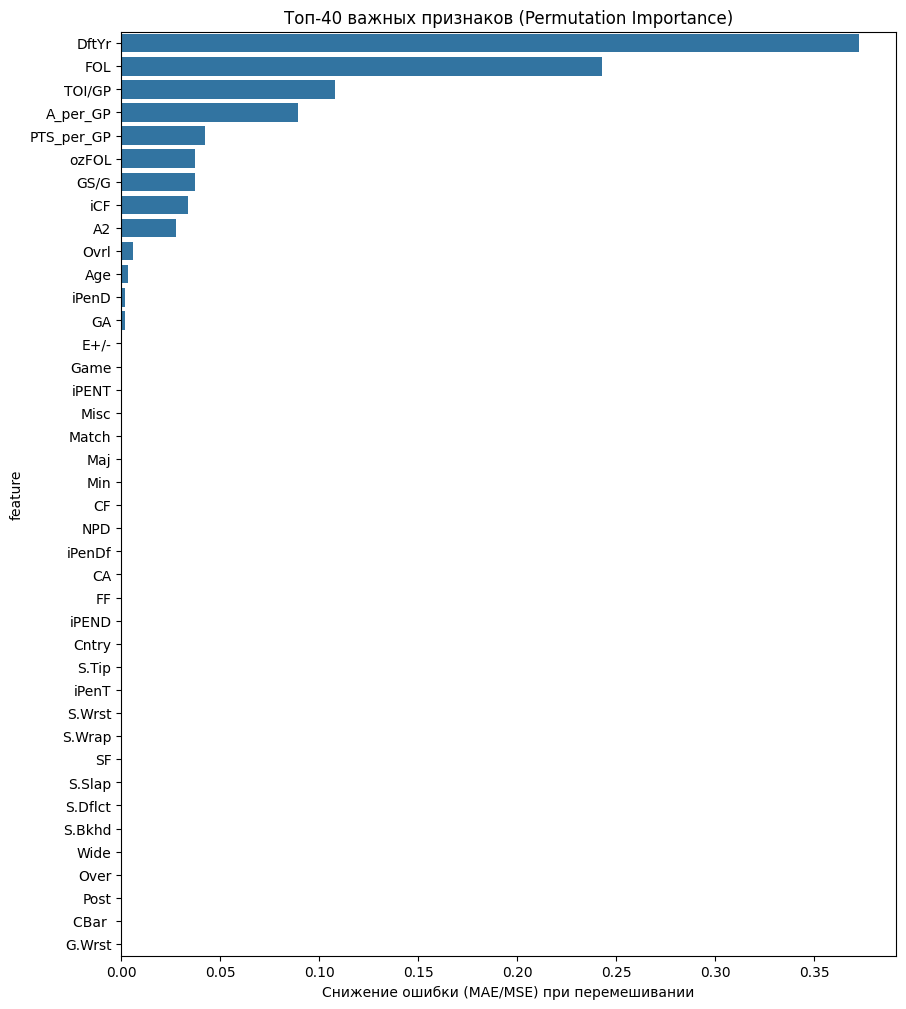

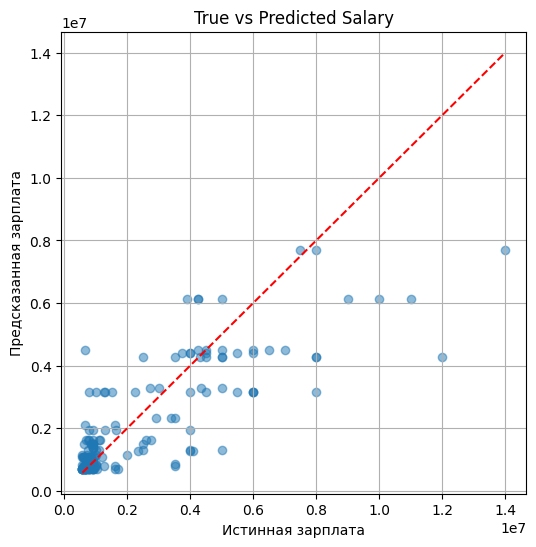

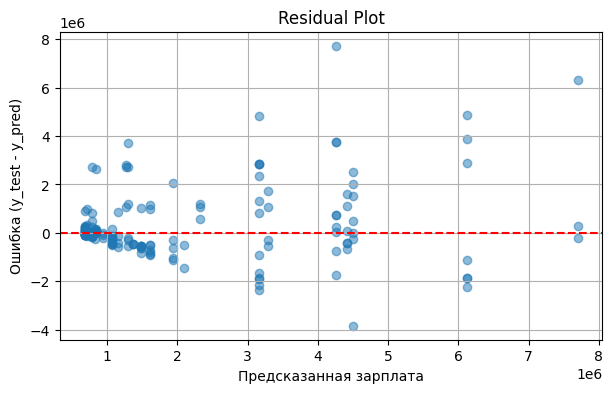

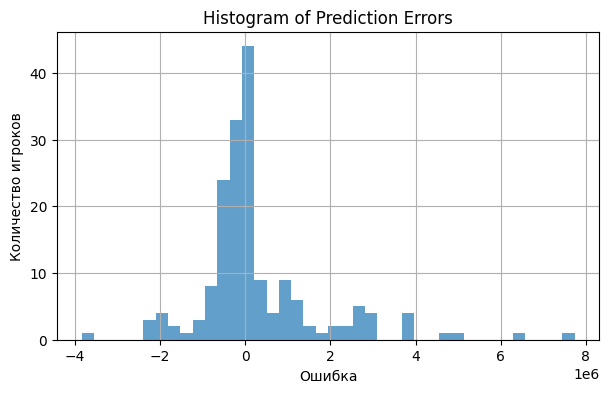

In [16]:
important_features(grid.best_estimator_, X_test_i, y_test_i)
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Решающему дереву тяжело найти сложную зависимость, поэтому оно записывает тут большая дискретизация получается. Многим игрокам модель ставит одну и ту же зарплату. Но в целом даже неплохо, получилось лучше, чем в KNN.

In [17]:
original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X_i)

results_df = pd.DataFrame({
    'True_Salary': y_i,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name Last Name  True_Salary  Predicted_Salary  Absolute_Error
542       Shea     Weber  12000000.00        4262683.20      7737316.80
103    Patrick      Kane  13800000.00        6123924.62      7676075.38
626       Anze   Kopitar  14000000.00        7698442.19      6301557.81
817     Steven   Stamkos   9500000.00        3289625.10      6210374.90
496   Jonathan     Toews  13800000.00        7698442.19      6101557.81
861      Corey     Perry  10000000.00        4493458.47      5506541.53
721       Sean   Monahan   6500000.00        1481300.80      5018699.20
564       Ryan  Callahan   6500000.00        1609227.50      4890772.50
208       P.K.    Subban  11000000.00        6123924.62      4876075.38
868       Loui  Eriksson   8000000.00        3164706.55      4835293.45


Ши Веббер конечно не играл на ту зарплату, которую получал. К 2016 году он был уже на закате карьеры, но всё еще получал много по старому контракту.

In [18]:
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name Last Name  True_Salary  Predicted_Salary  Signed_Error
665     Justin   Schultz    1400000.0      6.123925e+06  4.723925e+06
849        Sam    Gagner     650000.0      4.493458e+06  3.843458e+06
223       Kyle    Turris    4000000.0      7.698442e+06  3.698442e+06
532      Radim    Vrbata    1000000.0      4.493458e+06  3.493458e+06
659     Artemi   Panarin     925000.0      4.410530e+06  3.485530e+06
830    Patrick     Eaves    1000000.0      4.262683e+06  3.262683e+06
313      Brian    Strait     600000.0      3.289625e+06  2.689625e+06
302        Tom     Pyatt     800000.0      3.164707e+06  2.364707e+06
412       Mark  Barberio     800000.0      3.164707e+06  2.364707e+06
863      Brian  Dumoulin     800000.0      3.164707e+06  2.364707e+06


А тут интересно два человека: Дмитрий Орлов -- игрок Вашингтон Кэпиталз, надёжный защитник, который уже чз пару лет возьмет кубок Стэнли вместе с Александром Овечкиным. А второй -- это Марк Барберио, который сейчас играет в Северстали. На мой взгляд, он получал именно те деньги, которые заслужил в этом сезоне: 26 игр, 4 очка, 15 минут среднее игровое время. Слабо работает решающее дерево.

### My implementation

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, max_depth=None, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.root = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.n_features_ = X.shape[1]
        self.root = self._build_tree(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.array([self._make_prediction(x, self.root) for x in X])

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (num_samples < self.min_samples_leaf * 2) or \
           (np.var(y) == 0):
            return Node(value=np.mean(y))

        best_split = self._get_best_split(X, y, num_features)

        if best_split["gain"] > 0:
            left_subtree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
            right_subtree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
            return Node(
                feature_index=best_split["feature_index"],
                threshold=best_split["threshold"],
                left=left_subtree,
                right=right_subtree
            )
        return Node(value=np.mean(y))

    def _get_best_split(self, X, y, num_features):
        best_split = {"gain": -1, "feature_index": None, "threshold": None}
        max_gain = -float("inf")
        current_uncertainty = np.var(y) * len(y)

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]

                current_split_uncertainty = (len(y_left) * np.var(y_left)) + (len(y_right) * np.var(y_right))
                gain = current_uncertainty - current_split_uncertainty

                if gain > max_gain:
                    max_gain = gain
                    best_split = {
                        "feature_index": feature_index,
                        "threshold": threshold,
                        "X_left": X[left_mask],
                        "y_left": y_left,
                        "X_right": X[right_mask],
                        "y_right": y_right,
                        "gain": gain
                    }
        return best_split

    def _make_prediction(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._make_prediction(x, node.left)
        else:
            return self._make_prediction(x, node.right)

In [20]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

dt = DecisionTreeRegressor(random_state=42, max_depth=None, min_samples_leaf=1)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, np.full(len(y_test), y_train.mean()))

print("--- Decision Tree Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Decision Tree Regressor ---
MAE: 1220967.395
R2 Score: 0.322


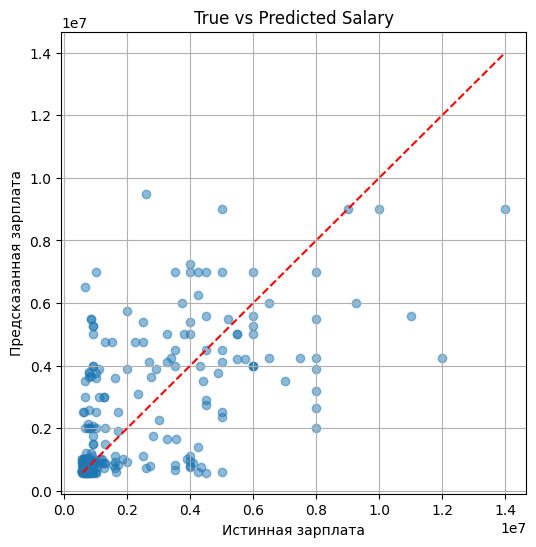

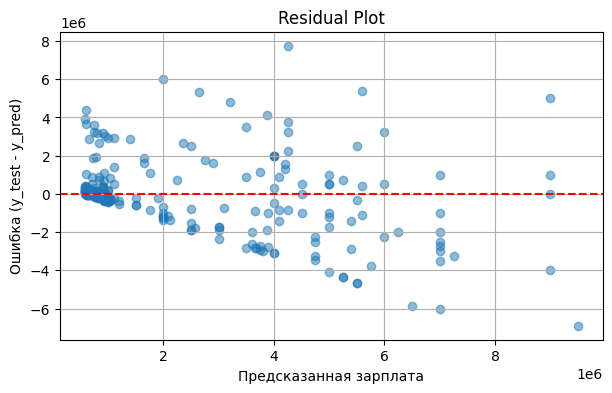

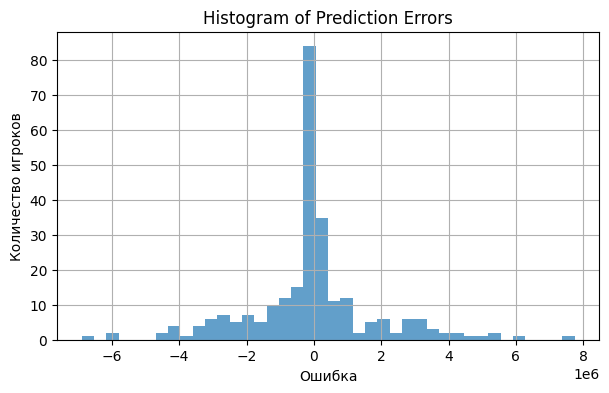

In [21]:
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Лучшие параметры: {'model_wrapper__regressor__max_depth': 5, 'model_wrapper__regressor__min_samples_leaf': 15}

--- Decision Tree Regressor ---
MAE: 870330.527
Train MAE: 743009.212
R2 Score: 0.632


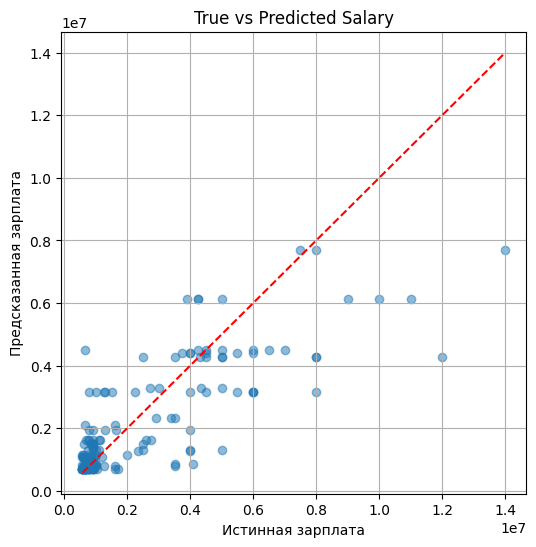

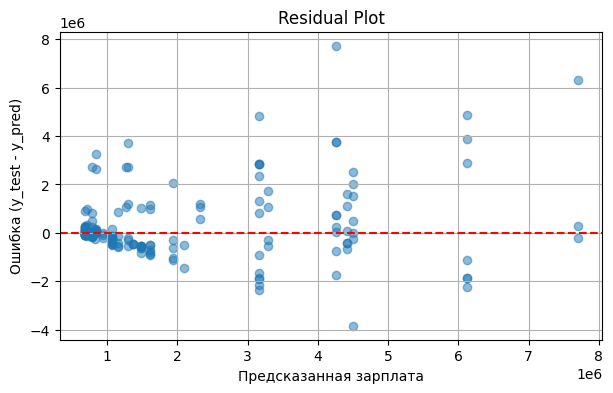

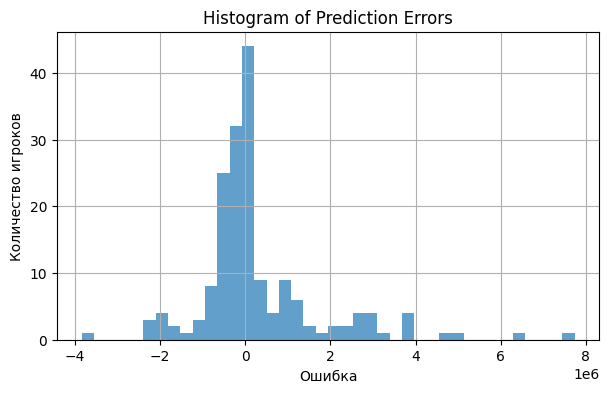

In [22]:
full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=MyDecisionTreeRegressor(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'model_wrapper__regressor__max_depth': [3, 5],
    'model_wrapper__regressor__min_samples_leaf': [10, 15],
}

grid = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print("Лучшие параметры:", grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)
y_pred_train = grid.best_estimator_.predict(X_train_i)

mae = mean_absolute_error(y_test_i, y_pred)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Decision Tree Regressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Моя модель не сильно хуже, чем реализация scikit-learn, но при этом сильно медленнее. В моей реализации отсутсвует pruning, плюс алгоритм поиска значений медленный. Но тут совсем незначительные изменения получаются.

|     | Base Decision Tree | Decision Tree | My Decision Tree |
|-----|--------------------|---------------|------------------|
| MAE | 1220967.395        | 865388.517    | 870330.527       |
| R2  | 0.322              | 0.635         | 0.632            |

## Классификация
Задача: вычислить мошенника на страховых выплатах с использованием модели решающего дерева

Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

### Baseline Desicion Tree

In [23]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [24]:
df_clean = df.copy()

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean["property_damage"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean = df_clean.fillna(0)

In [25]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,940,2,1,1000,1406.91,0,466132,...,1.0,71610,6510,13020,52080,10,1,2004,1,0.0
1,228,42,342868,635,1,1,2000,1197.22,5000000,468176,...,-1.0,5070,780,780,3510,8,12,2007,1,0.0
2,134,29,687698,413,2,0,2000,1413.14,5000000,430632,...,0.0,34650,7700,3850,23100,4,30,2007,0,0.0
3,256,41,227811,19,0,1,2000,1415.74,6000000,608117,...,0.0,63400,6340,6340,50720,3,34,2014,1,0.0
4,228,44,367455,922,0,2,1000,1583.91,6000000,610706,...,0.0,6500,1300,650,4550,0,31,2009,0,0.0


In [26]:
from sklearn.model_selection import train_test_split
drop_dates = ["policy_bind_date", "incident_date"]
df_clean = df_clean.drop(drop_dates, axis=1)
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve

model = DecisionTreeClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.5987
ROC-AUC: 0.7379
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       226
           1       0.57      0.64      0.60        74

    accuracy                           0.79       300
   macro avg       0.72      0.74      0.73       300
weighted avg       0.80      0.79      0.79       300



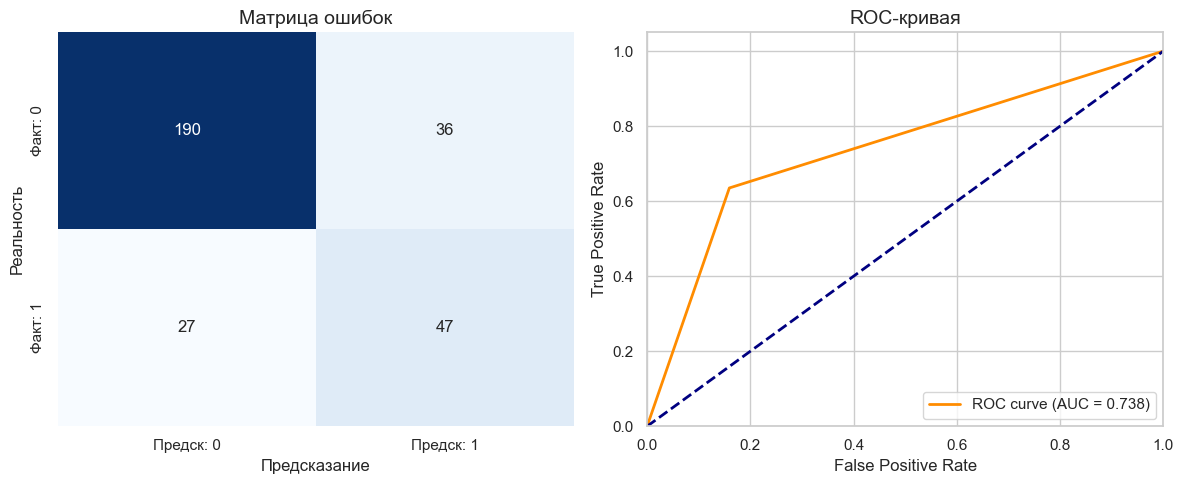

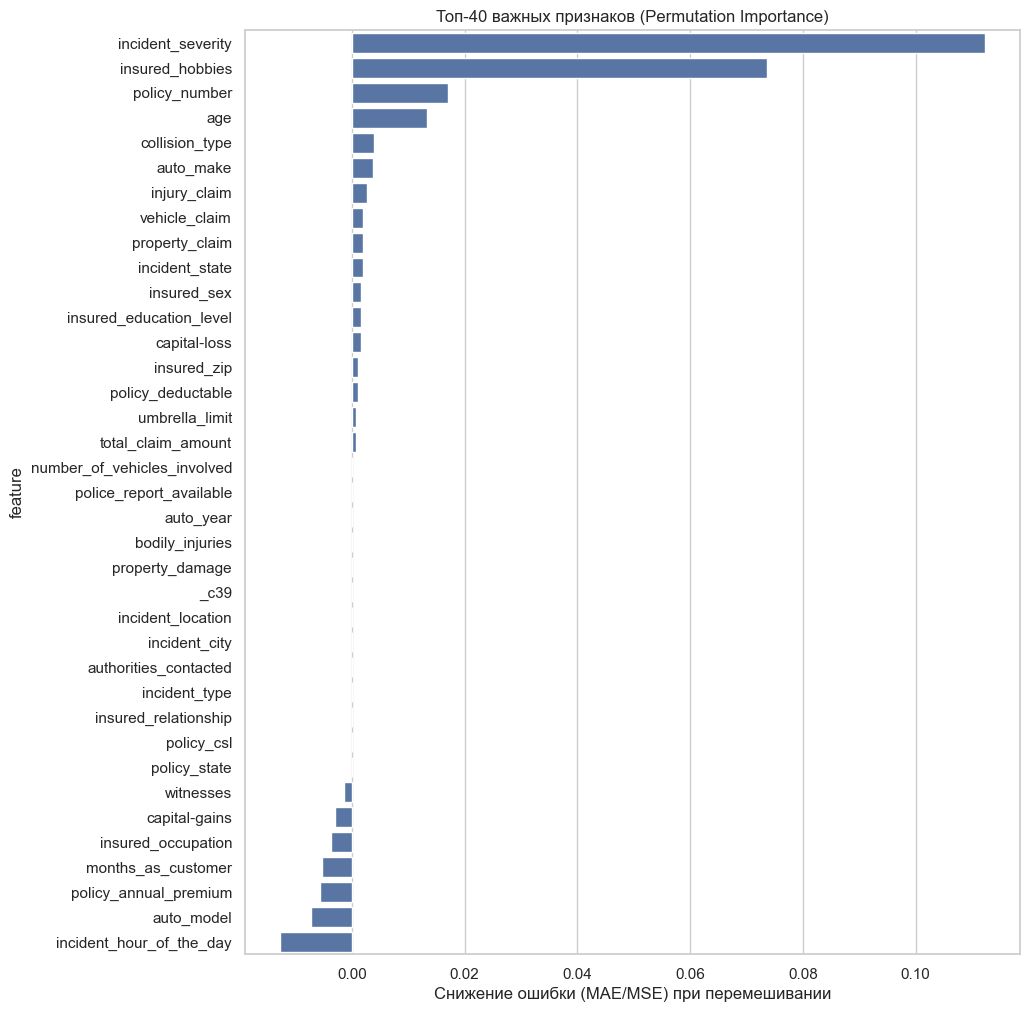

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
def feature_important(model, X_test, y_test):

    perm_result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    perm_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': perm_result.importances_mean
    })

    top_40_perm = perm_df.sort_values(by='importance', ascending=False).head(40)

    plt.figure(figsize=(10, 12))
    sns.barplot(data=top_40_perm, x='importance', y='feature')
    plt.title("Топ-40 важных признаков (Permutation Importance)")
    plt.xlabel("Снижение ошибки (MAE/MSE) при перемешивании")
    plt.show()
graphics(y_test, y_pred, y_prob)
feature_important(model, X_test, y_test)

Решающее дерево даже без преобработки показывает очень хорошие результаты. Вероятно это связано с тем, что модель не зависима от нормализации данных как KNN и Logistic Resgressor.

### Improved Decision Tree

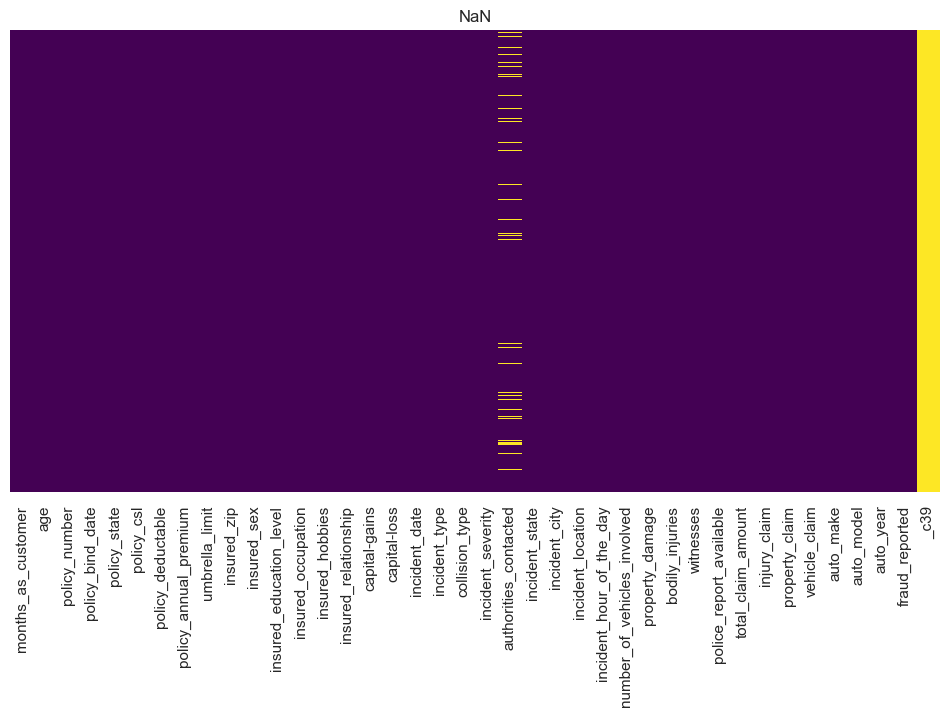

In [29]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df.head()

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [30]:
df_clean = df.copy()
df_clean["fraud_reported"].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

In [31]:
display(df_clean["police_report_available"].unique())
display(df_clean["property_damage"].unique())

array(['YES', '?', 'NO'], dtype=object)

array(['YES', '?', 'NO'], dtype=object)

In [32]:
df_clean = df_clean.drop(columns=["_c39"])

df_clean["authorities_contacted"] = df_clean["authorities_contacted"].fillna("No Contact")

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0, '?': -1})
df_clean["property_damage"] = df_clean["property_damage"].map({'YES': 1, 'NO': 0, '?': -1})

dates_cols = ["policy_bind_date", "incident_date"]
for c in dates_cols:
    df_clean[c] = pd.to_datetime(df_clean[c])

df_clean

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,1,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,-1,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,0,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,-1,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,-1,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,1,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,1,46980,5220,5220,36540,Audi,A5,1998,0


In [33]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_clean[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,2.039540e+02,1.151132e+02,0.00,115.7500,199.5,276.250,479.00
age,1000.0,3.894800e+01,9.140287e+00,19.00,32.0000,38.0,44.000,64.00
policy_number,1000.0,5.462386e+05,2.570630e+05,100804.00,335980.2500,533135.0,759099.750,999435.00
policy_deductable,1000.0,1.136000e+03,6.118647e+02,500.00,500.0000,1000.0,2000.000,2000.00
policy_annual_premium,1000.0,1.256406e+03,2.441674e+02,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,1.101000e+06,2.297407e+06,-1000000.00,0.0000,0.0,0.000,10000000.00
insured_zip,1000.0,5.012145e+05,7.170161e+04,430104.00,448404.5000,466445.5,603251.000,620962.00
capital-gains,1000.0,2.512610e+04,2.787219e+04,0.00,0.0000,0.0,51025.000,100500.00
capital-loss,1000.0,-2.679370e+04,2.810410e+04,-111100.00,-51500.0000,-23250.0,0.000,0.00
incident_hour_of_the_day,1000.0,1.164400e+01,6.951373e+00,0.00,6.0000,12.0,17.000,23.00


In [34]:
import numpy as np

df_pr = df_clean.copy()

median_value = df_pr.loc[df_pr['umbrella_limit'] != -100000, 'umbrella_limit'].median()
df_pr.loc[df_pr['umbrella_limit'] == -100000, 'umbrella_limit'] = median_value

In [35]:
df_features = df_pr.copy()

df_clean["policy_tenure_months"] = ((df_clean["incident_date"] - df_clean["policy_bind_date"]).dt.days / 30).astype(int)

df_features["incident_year"] = df_features["incident_date"].dt.year
df_features["incident_month"] = df_features["incident_date"].dt.month
df_features["incident_dow"] = df_features["incident_date"].dt.dayofweek
df_features["is_weekend"] = df_features["incident_dow"].isin([5, 6]).astype(int)

df_features["injury_ratio"] = df_features["injury_claim"] / (df_features["total_claim_amount"] + 1e-3)
df_features["property_ratio"] = df_features["property_claim"]  / (df_features["total_claim_amount"] + 1e-3)
df_features["vehicle_ratio"] = df_features["vehicle_claim"] / (df_features["total_claim_amount"] + 1e-3)

drop_dates = ["policy_bind_date", "incident_date"]
df_features = df_features.drop(drop_dates, axis=1)

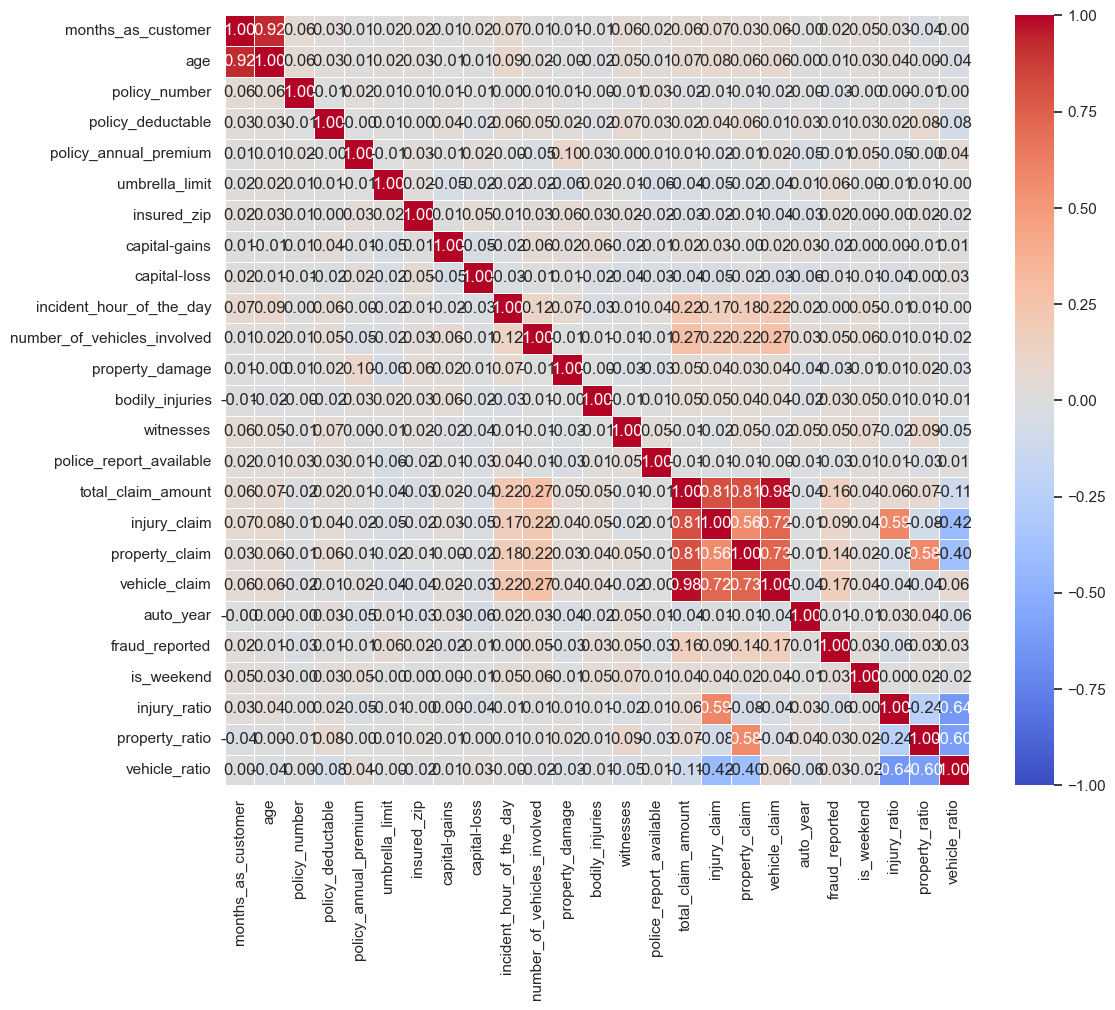

In [36]:
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_features[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

In [37]:
from sklearn.model_selection import train_test_split
X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.25, random_state=42, stratify=y_i)

Я удалил нормализацию из пайплайна, поскольку она не нужна для решающего дерева. Добавил параметры в сетку для решающего дерева. Также я вернул сюда OneHot Encoder для лучшей интерпретации результатов, хоть ROC_AUC и незначительно падает.

Поскольку я убрал нормализацию, я убрал и KNN импутер, который нормально работает только с нормализованными данными. Теперь используется просто медиана.

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report

num_cols = X_train_i.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train_i.select_dtypes(include=["object", "category"]).columns.tolist()

categorical_pipe = Pipeline([
    ("onehot", OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        sparse_output=False,
        min_frequency=2
    ))
])

ct = ColumnTransformer([
    ("cat", categorical_pipe, cat_cols)
])

model_pipe = Pipeline([
    ('ct', ct),
    ('model', DecisionTreeClassifier(random_state=42))
])

param_grid = {
    'model__max_depth': [5, 8, 10, 12, 15, None],
    'model__min_samples_leaf': [2, 4, 8, 10],
    'model__ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.02],
    'model__criterion': ['gini', 'entropy']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(f"Лучшие параметры: {grid.best_params_}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print("-" * 30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Лучшие параметры: {'model__ccp_alpha': 0.005, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 10}
------------------------------
F1-score (класс 1): 0.7347
ROC-AUC: 0.8611
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       188
           1       0.64      0.87      0.73        62

    accuracy                           0.84       250
   macro avg       0.79      0.85      0.81       250
weighted avg       0.87      0.84      0.85       250



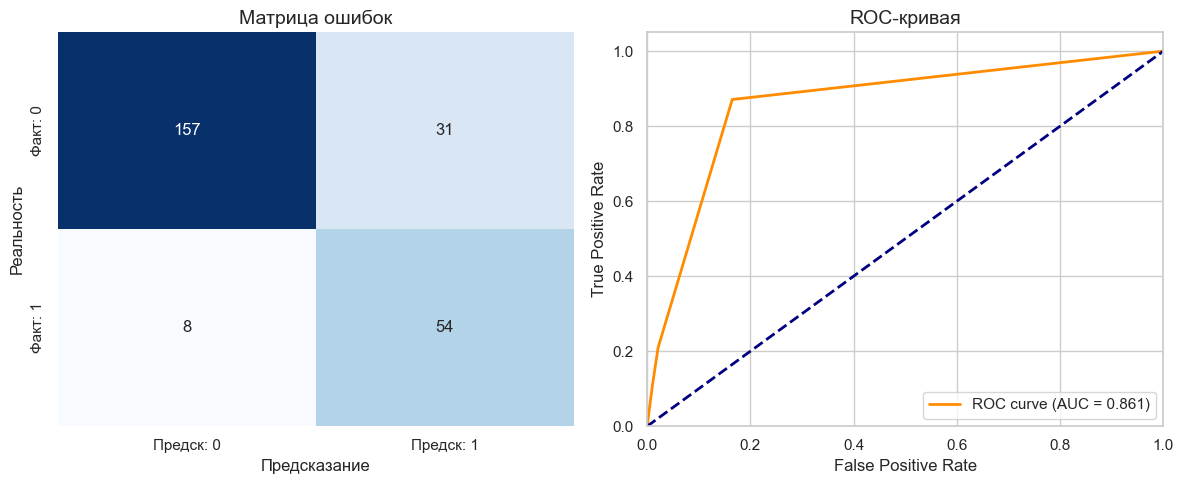

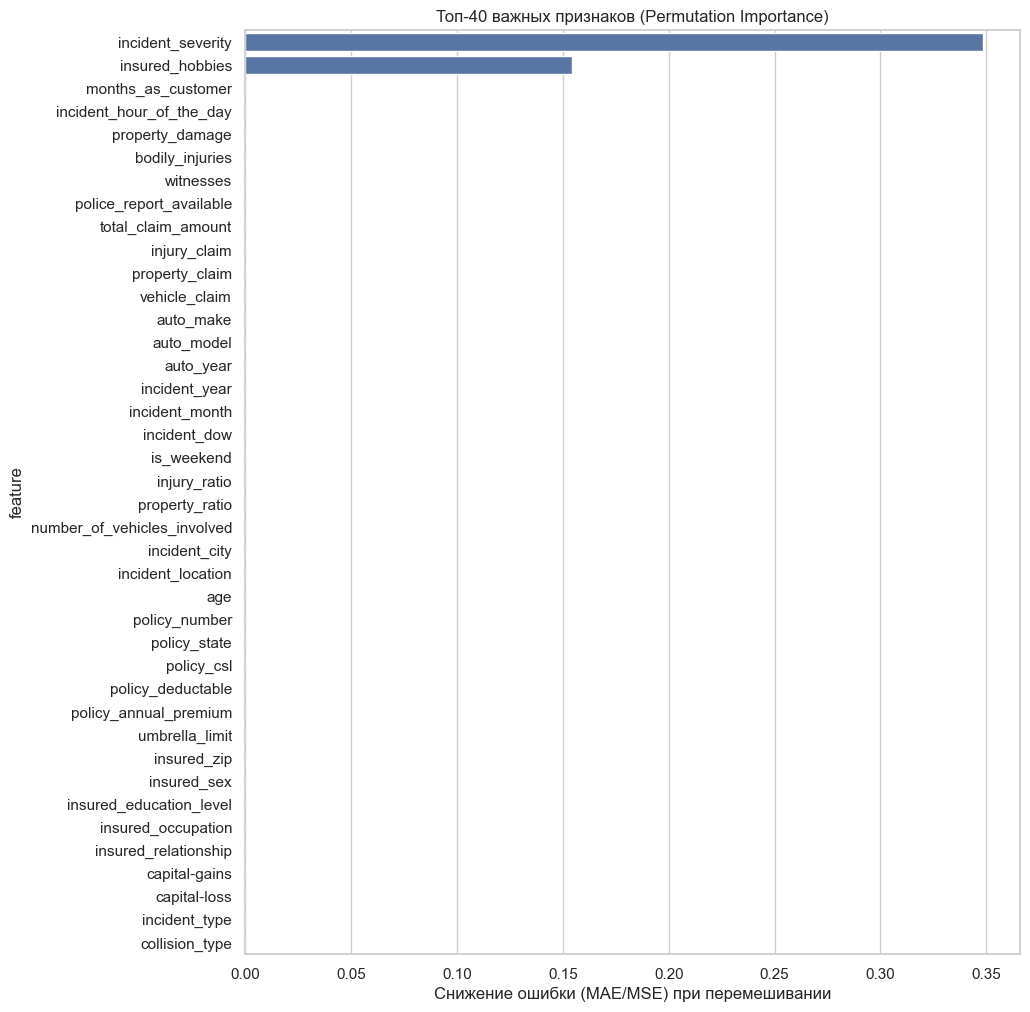

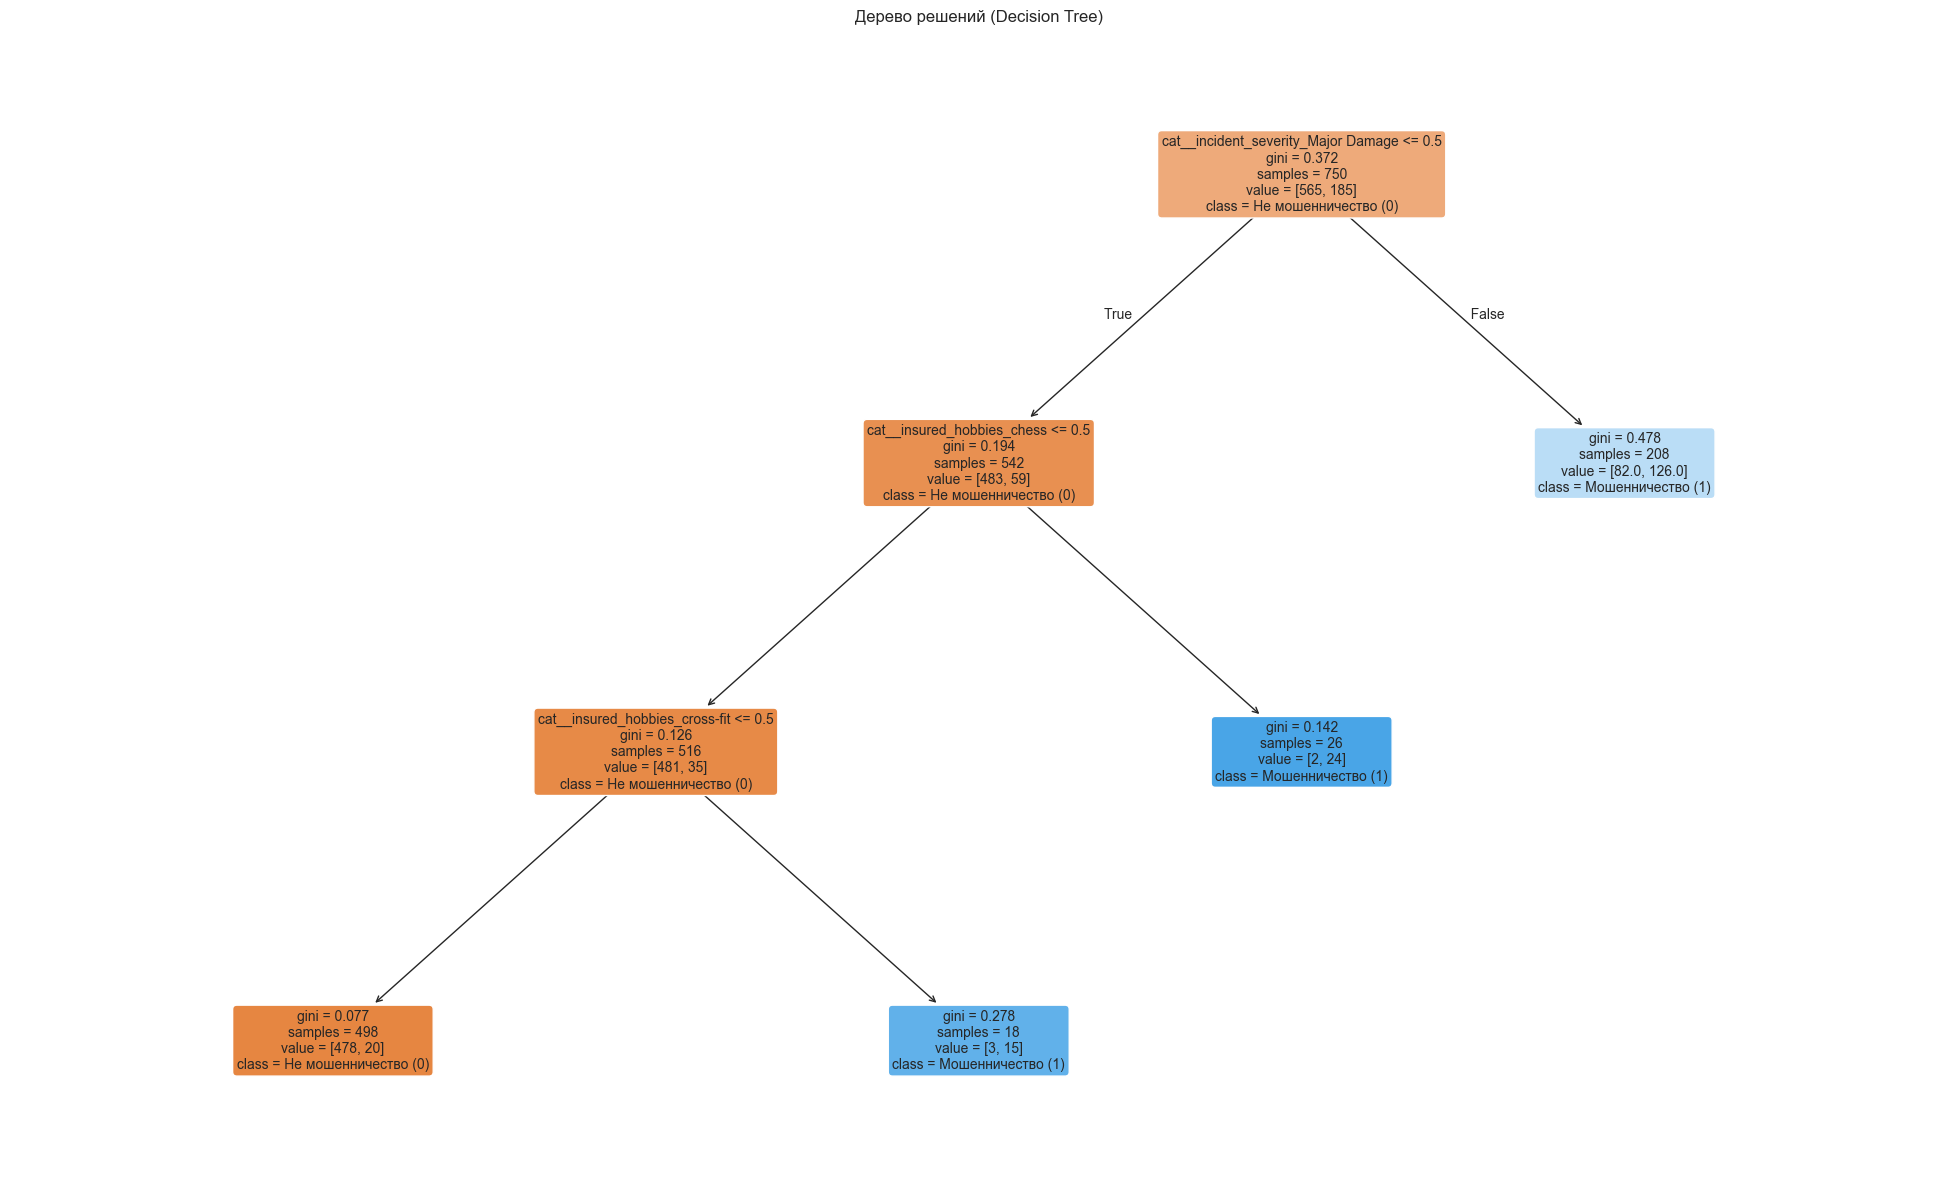

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

def tree_plot(fitted_grid):
    best_dt_model = fitted_grid.best_estimator_['model']
    ct_fitted = fitted_grid.best_estimator_['ct']

    feature_names = ct_fitted.get_feature_names_out()

    import matplotlib.pyplot as plt
    from sklearn.tree import plot_tree

    plt.figure(figsize=(25, 15))

    plot_tree(
        best_dt_model,
        feature_names=feature_names,
        class_names=['Не мошенничество (0)', 'Мошенничество (1)'],
        filled=True,
        rounded=True,
        fontsize=10
    )
    plt.title("Дерево решений (Decision Tree)")
    plt.show()

graphics(y_test_i, y_pred, y_prob)
feature_important(grid, X_test_i, y_test_i)
tree_plot(grid)

Решающее дерево почти не теряет мошенников, это очень хорошо. Также получилась интересная форма ROC_AUC кривой. Тут мы видим острые углы, поскольку решающее дерево имеет низкую разрешающую способность, что мы и видим по построению дерева.

Довольно забавно, что хобби так сильно влияют на то, является ли человек мошенник xD

### My implementation

In [40]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                 value=None, proba=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.proba = proba

class MyDecisionTreeClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, max_depth=None, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)
        self.n_features_ = X.shape[1]

        self.root = self._build_tree(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.array([self._make_prediction(x, self.root) for x in X])

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)

        probas = []
        for x in X:
            node_probs = self._get_node_proba(x, self.root)
            row_proba = [node_probs.get(c, 0.0) for c in self.classes_]
            probas.append(row_proba)

        return np.array(probas)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        unique_classes = len(np.unique(y))

        if (self.max_depth is not None and depth >= self.max_depth) or \
           (num_samples < self.min_samples_leaf * 2) or \
           (unique_classes == 1):
            return self._create_leaf_node(y)

        best_split = self._get_best_split(X, y, num_features)

        if best_split["gain"] > 0:
            left_subtree = self._build_tree(best_split["X_left"], best_split["y_left"], depth + 1)
            right_subtree = self._build_tree(best_split["X_right"], best_split["y_right"], depth + 1)
            return Node(
                feature_index=best_split["feature_index"],
                threshold=best_split["threshold"],
                left=left_subtree,
                right=right_subtree
            )

        return self._create_leaf_node(y)

    def _create_leaf_node(self, y):
        counts = Counter(y)
        most_common = counts.most_common(1)[0][0]
        total = len(y)
        probs = {cls: count / total for cls, count in counts.items()}
        return Node(value=most_common, proba=probs)

    def _get_best_split(self, X, y, num_features):
        best_split = {"gain": -1, "feature_index": None, "threshold": None}
        max_info_gain = -float("inf")
        parent_impurity = self._calculate_impurity(y)

        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                n = len(y)
                n_l, n_r = len(y_left), len(y_right)
                child_impurity = (n_l / n) * self._calculate_impurity(y_left) + \
                                 (n_r / n) * self._calculate_impurity(y_right)
                info_gain = parent_impurity - child_impurity

                if info_gain > max_info_gain:
                    max_info_gain = info_gain
                    best_split = {
                        "feature_index": feature_index,
                        "threshold": threshold,
                        "X_left": X[left_mask],
                        "y_left": y_left,
                        "X_right": X[right_mask],
                        "y_right": y_right,
                        "gain": info_gain
                    }
        return best_split

    def _calculate_impurity(self, y):
        if len(y) == 0: return 0
        counts = np.unique(y, return_counts=True)[1]
        probabilities = counts / len(y)
        if self.criterion == 'gini':
            return 1 - np.sum(probabilities ** 2)
        elif self.criterion == 'entropy':
            return -np.sum(probabilities * np.log2(probabilities + 1e-9))
        else:
            raise ValueError("Unknown criterion. Use 'gini' or 'entropy'")

    def _make_prediction(self, x, node):
        if node.value is not None: return node.value
        if x[node.feature_index] <= node.threshold:
            return self._make_prediction(x, node.left)
        return self._make_prediction(x, node.right)

    def _get_node_proba(self, x, node):
        if node.proba is not None: return node.proba
        if x[node.feature_index] <= node.threshold:
            return self._get_node_proba(x, node.left)
        return self._get_node_proba(x, node.right)

Без предобработки

In [41]:
model = MyDecisionTreeClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.6065
ROC-AUC: 0.7423
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       226
           1       0.58      0.64      0.61        74

    accuracy                           0.80       300
   macro avg       0.73      0.74      0.73       300
weighted avg       0.80      0.80      0.80       300



С предобработкой

In [42]:
model_pipe = Pipeline([
    ('ct', ct),
    ('model', MyDecisionTreeClassifier())
])

param_grid = {
    'model__max_depth': [5, 8, 10, 12, 15, None],
    'model__min_samples_leaf': [2, 4, 8, 10],
    'model__criterion': ['gini', 'entropy']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(f"Лучшие параметры: {grid.best_params_}")

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print("-" * 30)
print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 10}
------------------------------
F1-score (класс 1): 0.6179
ROC-AUC: 0.8781
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       188
           1       0.62      0.61      0.62        62

    accuracy                           0.81       250
   macro avg       0.75      0.75      0.75       250
weighted avg       0.81      0.81      0.81       250



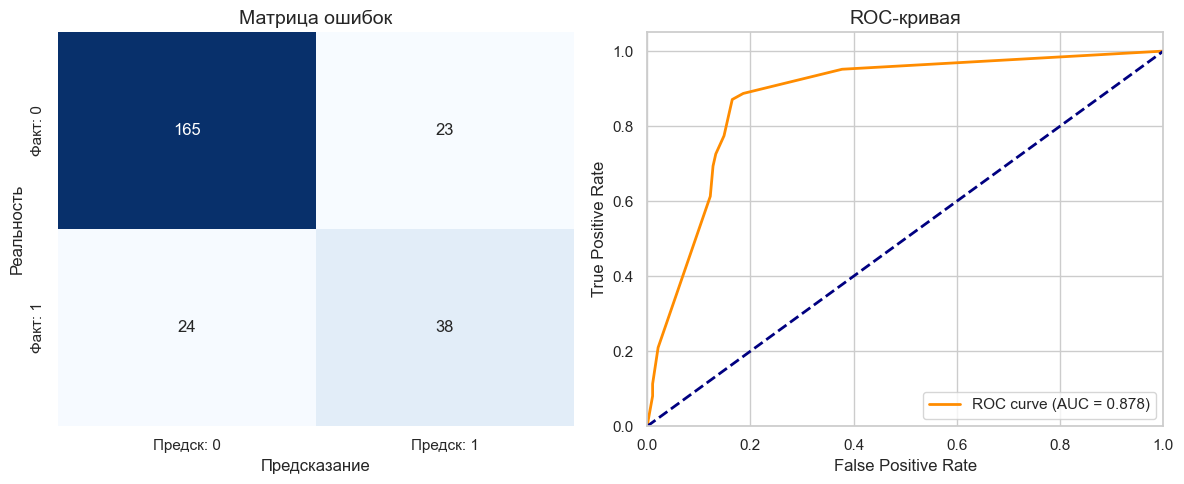

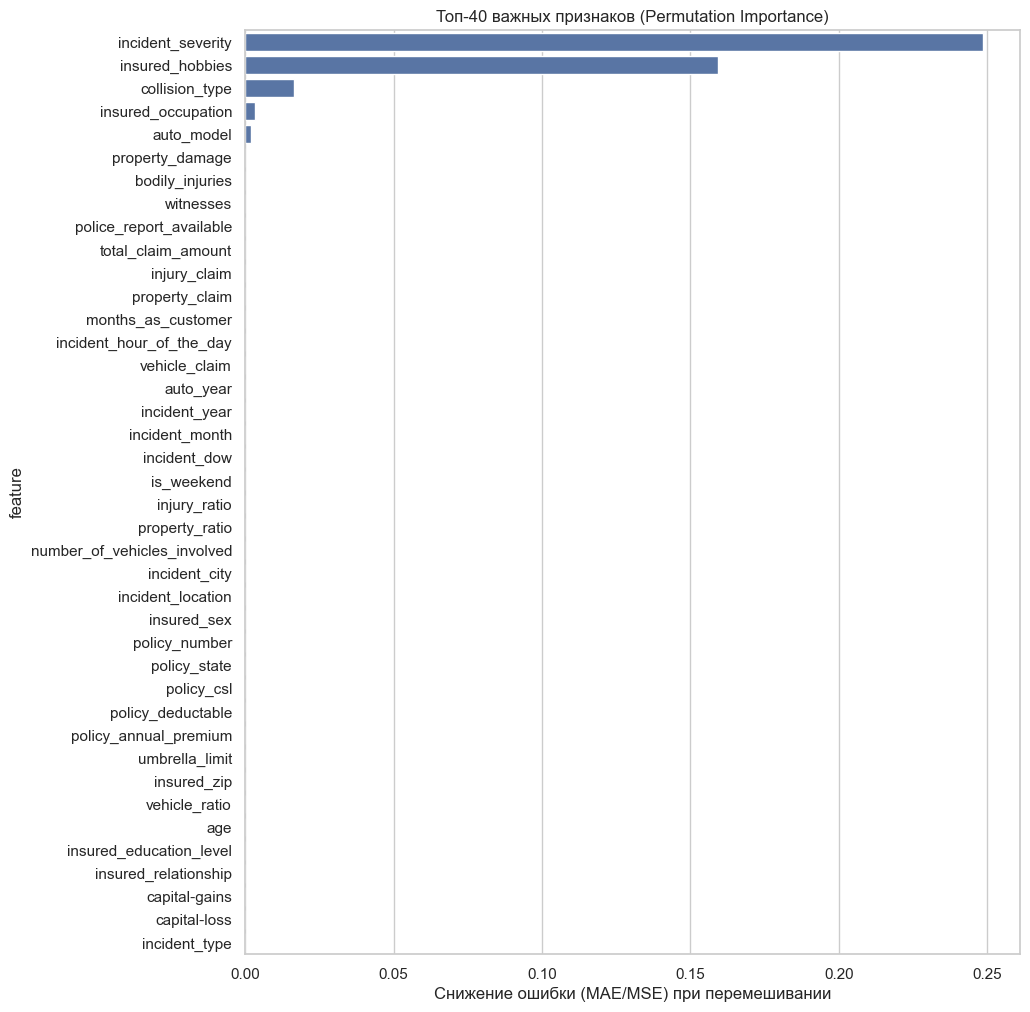

In [43]:
graphics(y_test_i, y_pred, y_prob)
feature_important(grid, X_test_i, y_test_i)

Моя модель получила даже лучший скор, чем имплементированная в scikit-learn, поскольку чаще угадывает честных. Но в реальной жизни эта модель была бы хуже, по выясненным ранее причинам. Вероятно это связано с отсутствием прунинга

|              | Base Decision Tree | Decision Tree | My Decision Tree |
|--------------|------------------------|---------------|------------------|
| ROC_AUC      | 0.7447                | 0.8611        | 0.8781           |
| F1 (1 класс) | 0.86                   | 0.89          | 0.88             |
| F1 (2 класс) | 0.61                  | 0.73          | 0.62             |

## Вывод

Решающее дерево хорошо тем, что мы можем легко понять, каким образом модель принимает решение. Кроме того, не нужно запариваться с нормализацией данных. При этом результаты, которые мы получаем на тестовой выборке очень хорошие. Единственная проблема заключается в том, что имплементация довольно сложная под капотом.